In [1]:
import sys
# sys.path
import ee
import pprint
from IPython.display import Image
# from image import Image as local_model
import openet.ssebop as local_model

gridded C version


In [2]:
try:
    ee.Initialize(use_cloud_api=True)
    print('worked')
except ee.EEException:
    ee.Authenticate()
    ee.Initialize(use_cloud_api=True)

worked


In [3]:

ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']

image_size = 768

In [4]:

landsat_img = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044033_20170716')
# landsat_img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_044033_20170801')

landsat_crs = landsat_img.select('B3').projection().getInfo()['crs']
landsat_region = landsat_img.geometry().bounds(1, 'EPSG:4326')
landsat_dt = ee.Date(landsat_img.get('system:time_start'))
# print(landsat_img.get('system:time_start').getInfo())

In [5]:
# Build the SSEBop object from the Landsat image
model_obj = local_model.Image.from_landsat_c1_toa(
    landsat_img,
    et_reference_source='IDAHO_EPSCOR/GRIDMET', 
    et_reference_band='etr', 
    et_reference_factor=0.85,
    et_reference_resample='nearest',
)

gridded-C branch!
Hello SSEBop! This is the gridded-c Branch of this model!


In [6]:
# image_url = model_obj.ndvi\
#     .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette, 
#                   'region': landsat_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')

In [7]:
# image_url = model_obj.et_fraction\
#     .getThumbURL({'min': 0.0, 'max': 1.2, 'palette': et_palette, 
#                   'region': landsat_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')

In [8]:
# Clip and project to the Landsat image footprint and coordinate system
image_url = model_obj.et_reference

lazy NDVI for gridded C


In [9]:
model_obj.et

In [13]:
model_obj.calculate(['et', 'et_reference', 'et_fraction'])

In [14]:
tcorr_image = model_obj.tcorr_image_gridded
print(type(tcorr_image.select(['tcorr'])))

<class 'ee.image.Image'>


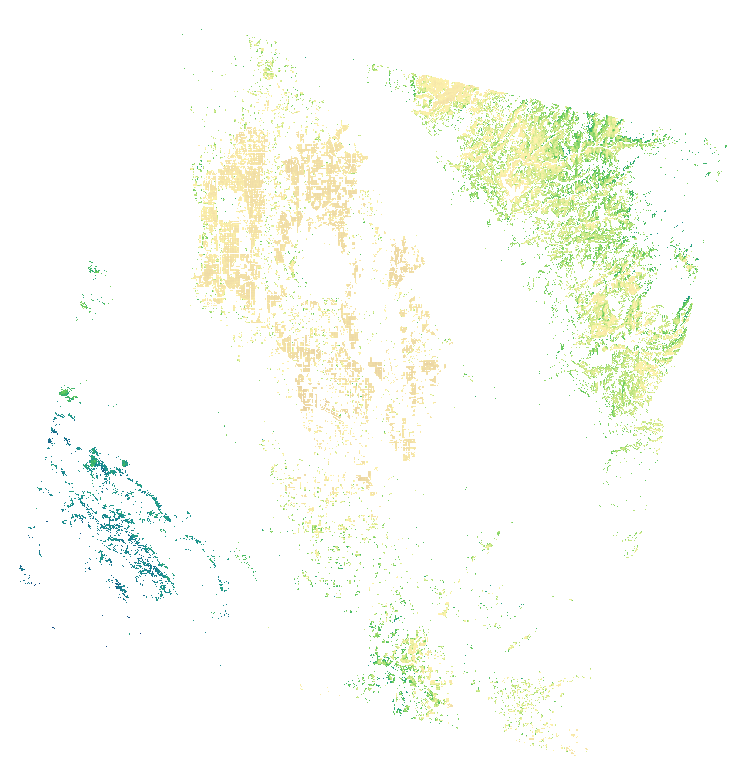

In [16]:
# plot tcorr image from the gridded output....

image_url = tcorr_image.getThumbURL({'min': 0.975, 'max': 1.05, 'palette': et_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')